In [1]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
import pandas as pd
from tqdm import tqdm
import webdataset as wds

import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenCLIPEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils
from models import *

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False)
device = accelerator.device
print("device:",device)

importing modules


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


LOCAL RANK  0
device: cuda


# Data

## New Design

In [2]:
sub = "sub-001"
session = "ses-01"
n_runs = 16

filename = f"csv/{sub}_{session}.csv"
print(filename)
data = pd.read_csv(filename)
images = data['current_image'].values[14:] # note: used to be [23:] in the earlier scans
starts = data['trial.started'].values[14:]
is_new_run = data['is_new_run'].values[14:]

unique_images = np.unique(images.astype(str))
unique_images = unique_images[(unique_images!="nan")]
unique_images = unique_images[(unique_images!="blank.jpg")]
len_unique_images = len(unique_images)
print("len_unique_images",len_unique_images)
print("n_runs",n_runs)

print(images[:4])
print(starts[:4])
print(is_new_run[:4])

image_idx = np.array([])
for i in range(len(images)):
    if images[i] == "blank.jpg":
        continue
    if str(images[i]) == "nan":
        continue

    image_idx_ = np.where(images[i]==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
image_idx = torch.Tensor(image_idx).long()

csv/sub-001_ses-03.csv
len_unique_images 708
n_runs 16
['all_stimuli/special515/special_69839.jpg'
 'all_stimuli/closest_pairs2/set_3_closest_to_pair_37_image_cocoid_45923.png'
 'all_stimuli/shared1000_notspecial/notspecial_28325.png'
 'all_stimuli/shared1000_notspecial/notspecial_46480.png']
[640.22436046 644.23800613 648.24092958 652.24105021]
[0. 0. 0. 0.]


In [3]:
import imageio
resize_transform = transforms.Resize((224, 224))
MST_images = []
images = None
for im_name in tqdm(image_idx):
    # im = imageio.imread(f"rtmindeye_stimuli/{(unique_images[im_name]).split('/')[-1]}")
    im = imageio.imread(f"{unique_images[im_name]}")
    im = torch.Tensor(im / 255).permute(2,0,1)
    im = resize_transform(im.unsqueeze(0))
    if images is None:
        images = im
    else:
        images = torch.vstack((images, im))
    if ("MST_pairs" in unique_images[im_name]): # ("_seed_" not in unique_images[im_name]) and (unique_images[im_name] != "blank.jpg") 
        MST_images.append(True)
    else:
        MST_images.append(False)

print("images", images.shape)
MST_images = np.array(MST_images)
print("MST_images", len(MST_images))
print("MST_images==True", len(MST_images[MST_images==True]))

  0%|          | 0/1008 [00:00<?, ?it/s]/tmp/ipykernel_1301744/3793407494.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(f"{unique_images[im_name]}")
/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using t

images torch.Size([1008, 3, 224, 224])
MST_images 1008
MST_images==True 150


In [4]:
pairs = utils.find_paired_indices(image_idx)
pairs = np.array(sorted(pairs, key=lambda x: x[0]))

In [5]:
glmsingle = np.load(f"glmsingle_{session}/TYPED_FITHRF_GLMDENOISE_RR.npz",allow_pickle=True) 

vox = glmsingle['betasmd'].T
print("vox", vox.shape)

if vox.ndim==4:
    vox = vox[:,0,0]
    print("vox", vox.shape)

vox (1008, 1, 1, 185890)
vox (1008, 185890)


Mask dimensions: (1.8, 1.8, 1.8)

Affine:
[[  1.79999995   0.           0.         -71.30000305]
 [  0.           1.79999995   0.         -78.40000153]
 [  0.           0.           1.79999995 -47.80000305]
 [  0.           0.           0.           1.        ]]

There are 185890 voxels in the included brain mask



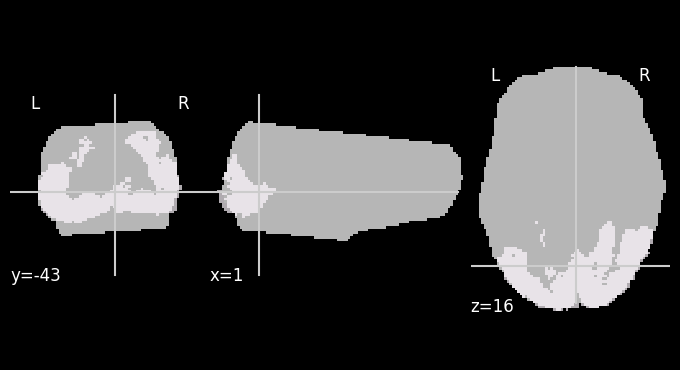

In [6]:
from nilearn.plotting import plot_roi, plot_anat, plot_epi

# avg_mask=nib.load(f'{sub}_ses-01_brain.nii.gz')
avg_mask=nib.load(f'masks/{sub}_{session}_brain.nii.gz')

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')

roi = nib.load(f'masks/{sub}_nsdgeneral.nii.gz')

plot_roi(roi, bg_img=avg_mask)

In [7]:
avg_mask = avg_mask.get_fdata().flatten()
print(f"total voxels (whole brain) = {int(avg_mask.sum())}")

roi = roi.get_fdata()
roi = roi.flatten()
roi = roi[avg_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(f"nsdgeneral voxels = {roi.sum()}")

total voxels (whole brain) = 185890
nsdgeneral voxels = 24213


In [8]:
# ROI masking?
print(f"vox before ROI exclusion: {vox.shape}")
vox = vox = vox[:,roi]
print(f"vox after ROI exclusion: {vox.shape}")

if np.any(np.isnan(vox)):
    print("NaNs found! Removing voxels...")
    x,y = np.where(np.isnan(vox))
    vox = vox[:,np.setdiff1d(np.arange(vox.shape[-1]), y)]

vox before ROI exclusion: (1008, 185890)
vox after ROI exclusion: (1008, 24213)


In [9]:
vox_pairs = utils.zscore(vox[pairs])
rels = np.full(vox.shape[-1],np.nan)
for v in tqdm(range(vox.shape[-1])):
    rels[v] = np.corrcoef(vox_pairs[:,0,v], vox_pairs[:,1,v])[1,0]
print("rels", rels.shape)
assert np.sum(np.all(np.isnan(rels))) == 0

100%|██████████| 24213/24213 [00:01<00:00, 23598.65it/s]

rels (24213,)


In [10]:
# Reliability thresholding?
print(f"\nvox before reliability thresholding: {vox.shape}")
vox = vox[:,rels>.2]
print(f"\nvox after reliability thresholding: {vox.shape}")


vox before reliability thresholding: (1008, 24213)

vox after reliability thresholding: (1008, 1394)


In [11]:
print(images.shape)
print(vox.shape)

torch.Size([1008, 3, 224, 224])
(1008, 1394)


In [12]:
utils.seed_everything(0)

# add_repeats = 48
# imageTrain = np.arange(len(images))
# train_image_indices = np.array([item for item in imageTrain if item not in pairs.flatten()])
# train_image_indices = np.sort(np.append(train_image_indices, np.array(pairs[:add_repeats].flatten())))

# # check that there's no repeat indices in training data
# assert len(sorted(np.append(np.array([item for item in imageTrain if item not in pairs.flatten()]), np.array(pairs[:add_repeats].flatten())))) == len(set(sorted(np.append(np.array([item for item in imageTrain if item not in pairs.flatten()]), np.array(pairs[:add_repeats].flatten())))))

# test_image_indices = pairs[add_repeats:]
# print(len(train_image_indices), len(test_image_indices))

# # train = all images except images that were repeated
# # test = average of the same-image presentations
# imageTrain = np.arange(len(images))
# train_image_indices = np.array([item for item in imageTrain if item not in pairs.flatten()])
# test_image_indices = pairs
# print(len(train_image_indices), len(test_image_indices))

# non-MST images are the train split
# MST images are the test split
train_image_indices = np.where(MST_images==False)[0]
test_image_indices = np.where(MST_images==True)[0]
print(len(train_image_indices), len(test_image_indices))

858 150


In [13]:
train_mean = np.mean(vox[train_image_indices],axis=0)
train_std = np.std(vox[train_image_indices],axis=0)

vox = utils.zscore(vox,train_mean=train_mean,train_std=train_std)
print("voxels have been zscored")
print(vox[:,0].mean(), vox[:,0].std())
print("vox", vox.shape)

images = torch.Tensor(images)
vox = torch.Tensor(vox)

voxels have been zscored
-0.021015354 1.0042804
vox (1008, 1394)


In [14]:
test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))

# Model

In [15]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = f"sub-001_{session}_bs24_MST_rishab_MSTsplit"  # "sub-001_bs24_4gpu" #"sub-001_bs24_MST" #"sub-001_bs24_4gpu"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2 \
                    --model_name={model_name} --subj=1 \
                    --no-blurry_recon --use_prior \
                    --hidden_dim=1024 --n_blocks=4"
    
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: sub-001_ses-03_bs24_MST_rishab_MSTsplit
--data_path=/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2                     --model_name=sub-001_ses-03_bs24_MST_rishab_MSTsplit --subj=1                     --no-blurry_recon --use_prior                     --hidden_dim=1024 --n_blocks=4


In [16]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="will load ckpt for model found in ../train_logs/model_name",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/mindeyev2_dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=2048,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--seq_len",type=int,default=1,
)
parser.add_argument(
    "--seed",type=int,default=42,
)
if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

# make output directory
os.makedirs("evals",exist_ok=True)
os.makedirs(f"evals/{model_name}",exist_ok=True)

In [17]:
subj_list = [subj]
subj = subj_list[0]
test_dl = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

Loaded test dl for subj1!



In [18]:
test_voxels, test_images = None, None
for test_i, behav in enumerate(test_dl):
    behav = behav[0]

    if behav.ndim>1:
        test_image = images[behav[:,0].long().cpu()].to(device)
        test_vox = vox[behav.long().cpu()].mean(1)
    else:
        test_image = images[behav.long().cpu()].to(device)
        test_vox = vox[behav.long().cpu()]
    
    if test_voxels is None:
        test_voxels = test_vox
        test_images = test_image
    else:
        test_voxels = torch.vstack((test_voxels, test_vox))
        test_images = torch.vstack((test_images, test_image))

print(test_i, len(test_voxels), len(test_images))

0 150 150


In [19]:
num_voxels_list = []
num_voxels_list.append(test_voxels.shape[-1])

In [20]:
## USING OpenCLIP ViT-bigG ###
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder

try:
    print(clip_img_embedder)
except:
    clip_img_embedder = FrozenOpenCLIPImageEmbedder(
        arch="ViT-bigG-14",
        version="laion2b_s39b_b160k",
        output_tokens=True,
        only_tokens=True,
    )
    clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

In [21]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len=1): 
        super(RidgeRegression, self).__init__()
        self.seq_len = seq_len
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(self.seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim)
utils.count_params(model.ridge)
utils.count_params(model)

from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=1, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=1, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim)
utils.count_params(model.backbone)
utils.count_params(model)

if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
1,428,480 total
1,428,480 trainable
param counts:
1,428,480 total
1,428,480 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
454,788,760 total
454,788,760 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
714,653,976 total
714,653,960 trainable


In [22]:
# Load pretrained model ckpt
tag='last'
outdir = os.path.abspath(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/{model_name}')
print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
checkpoint = torch.load(outdir+f'/{tag}.pth', map_location='cpu')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict, strict=True)
del checkpoint
print("ckpt loaded!")


---loading /scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/train_logs/sub-001_ses-03_bs24_MST_rishab_MSTsplit/last.pth ckpt---

ckpt loaded!


In [23]:
# prep unCLIP
config = OmegaConf.load("/scratch/gpfs/ri4541/MindEyeV2/src/generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38

diffusion_engine = DiffusionEngine(network_config=network_config,
                       denoiser_config=denoiser_config,
                       first_stage_config=first_stage_config,
                       conditioner_config=conditioner_config,
                       sampler_config=sampler_config,
                       scale_factor=scale_factor,
                       disable_first_stage_autocast=disable_first_stage_autocast)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)

ckpt_path = '/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/unclip6_epoch0_step110000.ckpt' 
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])

batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
      "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
      "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
print("vector_suffix", vector_suffix.shape)

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])


In [24]:
# setup text caption networks
from transformers import AutoProcessor, AutoModelForCausalLM
from modeling_git import GitForCausalLMClipEmb
# processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
# clip_text_model = GitForCausalLMClipEmb.from_pretrained("microsoft/git-large-coco")
processor = AutoProcessor.from_pretrained("/scratch/gpfs/ri4541/real_time_mindEye2/coco")
clip_text_model = GitForCausalLMClipEmb.from_pretrained("/scratch/gpfs/ri4541/real_time_mindEye2/coco")

clip_text_model.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
clip_text_model.eval().requires_grad_(False)
clip_text_seq_dim = 257
clip_text_emb_dim = 1024

class CLIPConverter(torch.nn.Module):
    def __init__(self):
        super(CLIPConverter, self).__init__()
        self.linear1 = nn.Linear(clip_seq_dim, clip_text_seq_dim)
        self.linear2 = nn.Linear(clip_emb_dim, clip_text_emb_dim)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.linear1(x)
        x = self.linear2(x.permute(0,2,1))
        return x
        
clip_convert = CLIPConverter()
state_dict = torch.load("bigG_to_L_epoch8.pth", map_location='cpu')['model_state_dict']
clip_convert.load_state_dict(state_dict, strict=True)
clip_convert.to(device) # if you get OOM running this script, you can switch this to cpu and lower minibatch_size to 4
del state_dict

In [ ]:
# get all reconstructions
model.to(device)
model.eval().requires_grad_(False)

all_blurryrecons = None
all_images = None
all_recons = None
all_predcaptions = []
all_clipvoxels = None
all_prior_out = None
all_backbones = None

minibatch_size = 32
num_samples_per_image = 1
plotting = False

with torch.no_grad():
    for batch in tqdm(range(0,len(test_images),minibatch_size)):
        start_time = time.time() 

        image = test_images[batch:batch+minibatch_size]
        voxel = test_voxels[batch:batch+minibatch_size].unsqueeze(1).to(device)

        # Save ground truth images
        if all_images is None:
            all_images = image
        else:
            all_images = torch.vstack((all_images, image))
        
        voxel_ridge = model.ridge(voxel,0)
        backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)
                
        # Save retrieval submodule outputs
        if clip_scale>0:
            if all_clipvoxels is None:
                all_clipvoxels = clip_voxels.cpu()
            else:
                all_clipvoxels = torch.vstack((all_clipvoxels, clip_voxels.cpu()))
                
        # Feed voxels through OpenCLIP-bigG diffusion prior
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20).cpu()
        
        if all_prior_out is None:
            all_prior_out = prior_out
        else:
            all_prior_out = torch.vstack((all_prior_out, prior_out))

        pred_caption_emb = clip_convert(prior_out.to(device).float())
        generated_ids = clip_text_model.generate(pixel_values=pred_caption_emb, max_length=20)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        all_predcaptions = np.hstack((all_predcaptions, generated_caption))
        print(generated_caption)
        
        # Feed diffusion prior outputs through unCLIP
        if plotting:
            jj=-1
            fig, axes = plt.subplots(1, 12, figsize=(10, 4))

        for i in range(len(voxel)):
            samples = utils.unclip_recon(prior_out[[i]],
                             diffusion_engine,
                             vector_suffix,
                             num_samples=num_samples_per_image)
            if all_recons is None:
                all_recons = samples.cpu()
            else:
                all_recons = torch.vstack((all_recons, samples.cpu()))
                
            if plotting:  
                jj+=1
                axes[jj].imshow(utils.torch_to_Image(image[i]))
                axes[jj].axis('off')
                jj+=1
                axes[jj].imshow(utils.torch_to_Image(samples.cpu()[0]))
                axes[jj].axis('off')
        
        plt.show()

        print(model_name)
        # err # dont actually want to run the whole thing with plotting=True

# resize outputs before saving
imsize = 256
all_images = transforms.Resize((imsize,imsize))(all_images).float()
all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
if blurry_recon: 
    all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()
        
eval_dir = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/evals/{model_name}"
## Saving ##
if not os.path.exists(eval_dir):
    os.mkdir(eval_dir)

# if "MST" in model_name:
#     np.save(f"{eval_dir}/{model_name}_MST_ID.npy", MST_ID)
torch.save(all_images.cpu(),f"{eval_dir}/{model_name}_all_images.pt")
torch.save(all_recons,f"{eval_dir}/{model_name}_all_recons.pt")
if clip_scale>0:
    torch.save(all_clipvoxels,f"{eval_dir}/{model_name}_all_clipvoxels.pt")
torch.save(all_prior_out,f"{eval_dir}/{model_name}_all_prior_out.pt")
torch.save(all_predcaptions,f"{eval_dir}/{model_name}_all_predcaptions.pt")
print(f"saved {model_name} outputs!")

  0%|          | 0/5 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a train is driving on the tracks.', 'a large room with a table and chairs.', 'a street with a lot of cars parked in it.', 'a large building with a lot of windows.', 'a large building with a lot of windows.', 'a large building with a clock on it.', 'a room with a lot of furniture.', 'a plane is parked on the runway.', 'a white and black bathroom.', 'a large building with a lot of windows.', 'a street with a lot of traffic.', 'a dining room with a table and chairs.', 'a plate of food', 'a large white airplane.', 'a bench with a bench and a bench.', 'a cat is sitting on a table.', 'a table with a plate of food on it', 'a woman standing on a tennis court.', 'a large room with a table and chairs.', 'a surfer is riding a wave.', 'a clock tower with a tower in the background.', 'a small table with a glass top.', 'a desk with a laptop and a monitor', 'a dining room with a table and chairs.', 'a building with a clock on it.', 'a white room with a sink and a mirror', 'a large building with a c

/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/ri4541/.conda/envs/rt_mindEye2/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 20%|██        | 1/5 [02:20<09:23, 140.88s/it]

sub-001_ses-03_bs24_MST_rishab_MSTsplit


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a table with a bunch of chairs', 'a table with a bunch of food on it', 'a building with a clock on it.', 'a boat on a body of water', 'a large room with a table and chairs.', 'a plate of food with a pizza on it.', 'a building with a clock on it.', 'a large group of people.', 'a clock tower with a tower in the background.', 'a large body of water', 'a train is driving past a train.', 'a plate of food with a fork.', 'a train is driving past a train.', 'a large building with a clock on it.', 'a view of a dining room.', 'a train is driving past a train.', 'a bathroom with a toilet and a sink.', 'a picture of a small building.', 'a building with a clock on it.', 'a plate of food.', "a stuffed animal with a stuffed animal in it's mouth.", 'a large building with a clock on it.', 'a large jetliner sitting on top of a tarmac.', 'a ski slope with a ski slope.', 'a small room with a lot of furniture.', 'a red and white bus', 'a surfer is riding a wave.', 'a large building with a clock on it.', 

 40%|████      | 2/5 [04:41<07:02, 140.87s/it]

sub-001_ses-03_bs24_MST_rishab_MSTsplit


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a dining room with a table and chairs.', 'a boat is parked on the water.', 'a large building with a lot of windows.', 'a building with a clock on it.', 'a surfer riding a wave on a surfboard.', 'a train is driving through a city.', 'a train is parked on the side of the road.', 'a close up of a person', 'a bathroom with a toilet and a sink.', 'a building with a tower and a clock.', 'a train is driving past a train.', 'a street with a car and a building.', 'a herd of zebra grazing.', 'a large bird sitting on top of a building.', 'a clock tower with a tower in the background.', 'a building with a clock on it.', 'a car driving down a street next to a bus.', 'a train is driving past a train.', 'a train is driving past a train.', 'a skier is skiing down a hill.', 'a white room with a lot of furniture.', 'a large white and black sign.', 'a plate of food on a table.', 'a train is driving down the tracks.', 'a train is parked on the tracks.', 'a man sitting in a chair.', 'a kitchen with a lot

 60%|██████    | 3/5 [07:02<04:41, 140.96s/it]

sub-001_ses-03_bs24_MST_rishab_MSTsplit


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

['a bathroom with a toilet and a sink.', 'a bunch of food on a table.', 'a skier is skiing down a hill.', 'a room with a view.', 'a kitchen with a sink and a stove', 'a large building with a clock on it.', 'a surfer riding a wave on a surfboard.', 'a stuffed toy.', 'a large white and black object.', 'a large group of people.', 'a kitchen with a table and chairs', 'a bunch of different types of food', 'a bench with a bench in front of it.', 'a bunch of bananas', 'a building with a clock on it.', 'a large building with a lot of windows.', 'a large group of people.', 'a zebra standing in the grass.', 'a train is parked on the tracks.', 'a bus driving down a street.', 'a man on a ski slope.', 'a small stuffed animal.', 'a man is holding a cell phone.', 'a bathroom with a sink and a mirror.', 'a train is driving down the tracks.', 'a plane is flying over a building.', 'a large building with a lot of windows.', 'a small animal in a fenced area.', 'a small room with a lot of furniture.', 'a t

In [30]:
# imsize = 256
# all_images = transforms.Resize((imsize,imsize))(all_images).float()
# all_recons = transforms.Resize((imsize,imsize))(all_recons).float()
# if blurry_recon: 
#     all_blurryrecons = transforms.Resize((imsize,imsize))(all_blurryrecons).float()

eval_dir = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/evals/{model_name}"
## Saving ##
if not os.path.exists(eval_dir):
    os.mkdir(eval_dir)

# # if "MST" in model_name:
#     # np.save(f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/evals/{model_name}/{model_name}_MST_ID.npy", MST_ID)
torch.save(all_images.cpu(),f"{eval_dir}/{model_name}_all_images.pt")
torch.save(all_recons,f"{eval_dir}/{model_name}_all_recons.pt")
if clip_scale>0:
    torch.save(all_clipvoxels,f"{eval_dir}/{model_name}_all_clipvoxels.pt")
torch.save(all_prior_out,f"{eval_dir}/{model_name}_all_prior_out.pt")
torch.save(all_predcaptions,f"{eval_dir}/{model_name}_all_predcaptions.pt")
print(f"saved {model_name} outputs!")

saved sub-001_ses-03_bs24_MST_rishab_MSTsplit outputs!


In [31]:
all_images.shape

torch.Size([150, 3, 256, 256])

In [32]:
x = torch.permute(all_images, (0,2,3,1))
y = torch.permute(all_recons, (0,2,3,1))

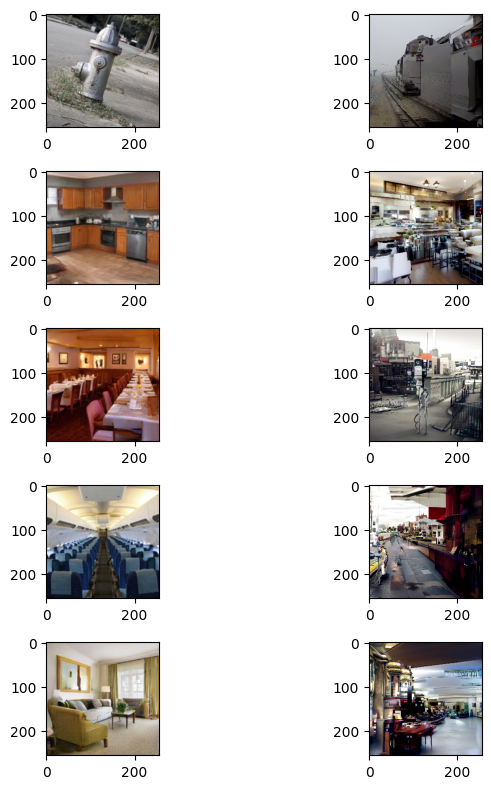

In [33]:
fig, ax = plt.subplots(5, 2, figsize=(8, 8))
for row, _ in enumerate(ax):
    ax[row][0].imshow(x.cpu()[row])
    ax[row][1].imshow(y.cpu()[row])
plt.tight_layout()
plt.show()